In [13]:
# for jupyter notebook plot;
using PyPlot;
PyPlot.svg(true);
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["svg.fonttype"] = "none";

# load affīnitās;
include("../adfinitas.jl");

# if you use parallel/distributed computing, load affīnitās to all proc;
adfinitasParallelStop();
adfinitasParallelStart(16);
@everywhere include("../adfinitas.jl");

# always remember calling adfinitasParallelStop() to stop other procs after simulation;

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /opt/julias/julia-1.9/share/julia/stdlib/v1.9/Distributed/src/cluster.jl:1049


In [14]:
# Example 1:
# This example shows solar system simulation;

simulationTime::BigFloat = 60 * 60 * 24 * (365 * 2);    # simulation time: 2 years;

sysTimeStep::BigFloat = 60 * 60;    # simulation step: 1 hour;
angleResolution::BigFloat = 2 * pi / 360;   # expected angle resolution: 1 degree;
gravitationalConstant::BigFloat = 6.67430 * (BigFloat(10) ^ (-11));   # define gravitational constant: G

configure = adfinitasParameters(gravitationalConstant, sysTimeStep, angleResolution); # define global parameter;

# a list of planets in the solar system, stop at Jupiter;
sunObj = adfinitasObject("Sun", 1.98847 * (BigFloat(10) ^ 30), adfinitasVector(0, 0, 0), adfinitasVector(0, 0, 0), 0);
mercuryObj = adfinitasObject("Mercury", 3.3011 * (BigFloat(10) ^ 23), adfinitasVector(5.791 * (BigFloat(10) ^ 10), 0, 0), adfinitasVector(0, 47360, 0), 0);
venusObj = adfinitasObject("Venus", 4.8675 * (BigFloat(10) ^ 24), adfinitasVector(1.0821 * (BigFloat(10) ^ 11), 0, 0), adfinitasVector(0, 35020, 0), 0);
earthObj =  adfinitasObject("Earth", 5.9722 * (BigFloat(10) ^ 24), adfinitasVector(1.495978707 * (BigFloat(10) ^ 11), 0, 0), adfinitasVector(0, 29780, 0), 0);
marsObj =  adfinitasObject("Mars", 6.4171 * (BigFloat(10) ^ 23), adfinitasVector(2.27939366000 * (BigFloat(10) ^ 11), 0, 0), adfinitasVector(0, 24070, 0), 0);
jupiterObj = adfinitasObject("Jupiter", 1.8982 * (BigFloat(10) ^ 27), adfinitasVector(7.78479 * (BigFloat(10) ^ 11), 0, 0), adfinitasVector(0, 13070, 0), 0);

# push all objects into an array;
objsArray = adfinitasEmptyObjectArray();
append!(objsArray, [sunObj]);
append!(objsArray, [mercuryObj]);
append!(objsArray, [venusObj]);
append!(objsArray, [earthObj]);
append!(objsArray, [marsObj]);
append!(objsArray, [jupiterObj]);

# this function checks if the global time step can fit the angle resolution, auto modify if not;
# if you want to use the other object which does not at (0, 0, 0) as the angle center, use adfinitasInitSpecifiedObject(configure::adfinitasParameters, object::adfinitasObject, angleCenterObject::adfinitasObject); 
objsArray = adfinitasInitObjects(configure, objsArray);

In [3]:
# run simulation
objsMotionList = adfinitasRun(configure, simulationTime, objsArray);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:50m


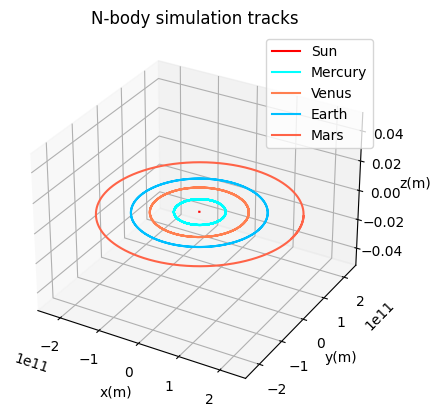

In [4]:
# load all track from simulation result;
sunPositionTrack, sunVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Sun", objsMotionList));
mercuryPositionTrack, mercuryVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Mercury", objsMotionList));
venusPositionTrack, venusVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Venus", objsMotionList));
earthPositionTrack, earthVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Earth", objsMotionList));
marsPositionTrack, marsVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Mars", objsMotionList));
jupiterPositionTrack, jupiterVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Jupiter", objsMotionList));

# plot the tracks;
legendList = [];
plot3D(sunPositionTrack.x, sunPositionTrack.y, sunPositionTrack.z, color = "red", marker = " ");
    append!(legendList, [sunObj.name]);
plot3D(mercuryPositionTrack.x, mercuryPositionTrack.y, mercuryPositionTrack.z, color = "cyan", marker = " ");
    append!(legendList, [mercuryObj.name]);
plot3D(venusPositionTrack.x, venusPositionTrack.y, venusPositionTrack.z, color = "coral", marker = " ");
    append!(legendList, [venusObj.name]);
plot3D(earthPositionTrack.x, earthPositionTrack.y, earthPositionTrack.z, color = "deepskyblue", marker = " ");
    append!(legendList, [earthObj.name]);
plot3D(marsPositionTrack.x, marsPositionTrack.y, marsPositionTrack.z, color = "tomato", marker = " ");
    append!(legendList, [marsObj.name]);
# Jupiter has a very large orbit, it is not beautiful on one plot
# plot3D(jupiterPositionTrack.x, jupiterPositionTrack.y, jupiterPositionTrack.z, color = "sienna", marker = " ");
    # append!(legendList, [jupiterObj.name]);

PyPlot.title("N-body simulation tracks");
PyPlot.xlabel("x(m)");
PyPlot.ylabel("y(m)");
PyPlot.zlabel("z(m)");
legend(legendList);
savefig("position.svg");

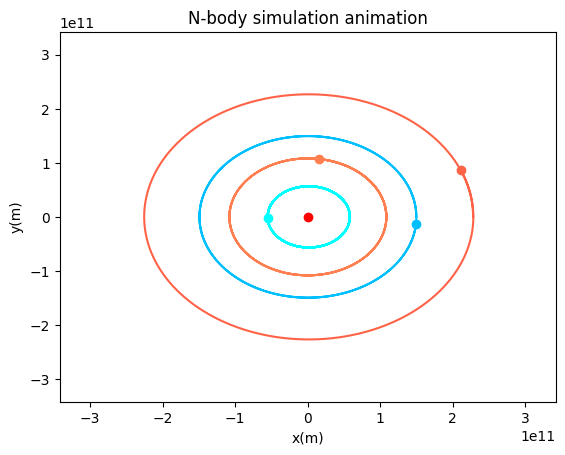

In [5]:
# export an animation of the former track;
using PyCall
@pyimport matplotlib.animation as animation

fig = figure();
frameLength = length(sunPositionTrack.time);
frameStep = floor(frameLength / 200);

function animate(outIndex)
    index = convert(Int64, (outIndex * frameStep)) + 1;
    clf();
    PyPlot.xlabel("x(m)");
    PyPlot.ylabel("y(m)");
    PyPlot.title("N-body simulation animation")
    lim = 1.5 * Float64(marsObj.position.x);
    PyPlot.xlim([-lim, lim]);
    PyPlot.ylim([-lim, lim]);
    plot(sunPositionTrack.x[1 : index], sunPositionTrack.y[1 : index], color = "red", marker = " ");
        plot(sunPositionTrack.x[index], sunPositionTrack.y[index], color = "red", marker = "o");
    plot(mercuryPositionTrack.x[1 : index], mercuryPositionTrack.y[1 : index], color = "cyan", marker = " ");
        plot(mercuryPositionTrack.x[index], mercuryPositionTrack.y[index], color = "cyan", marker = "o");
    plot(venusPositionTrack.x[1 : index], venusPositionTrack.y[1 : index], color = "coral", marker = " ");
        plot(venusPositionTrack.x[index], venusPositionTrack.y[index], color = "coral", marker = "o");
    plot(earthPositionTrack.x[1 : index], earthPositionTrack.y[1 : index], color = "deepskyblue", marker = " ");
        plot(earthPositionTrack.x[index], earthPositionTrack.y[index], color = "deepskyblue", marker = "o");
    plot(marsPositionTrack.x[1 : index], marsPositionTrack.y[1 : index], color = "tomato", marker = " ");
        plot(marsPositionTrack.x[index], marsPositionTrack.y[index], color = "tomato", marker = "o");
    # plot(jupiterPositionTrack.x[1 : index], jupiterPositionTrack.y[1 : index], color = "sienna", marker = " ");
        # plot(jupiterPositionTrack.x[index], jupiterPositionTrack.y[index], color = "sienna", marker = "o");
end

function init()
    animate(1);
end

withfig(fig) do 
    anime = animation.FuncAnimation(fig, animate, frames = convert(Int64, floor(frameLength / frameStep)), init_func = init, interval = 5, blit = true); 
    anime.save("animePosition.gif")
end

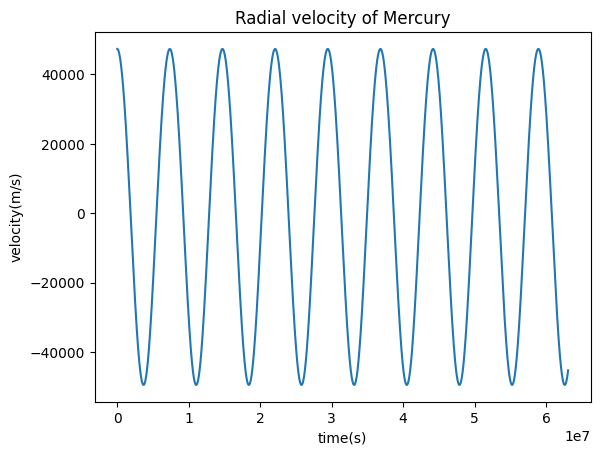

In [6]:
# get the radial velocity of Mercury;

PyPlot.title("Radial velocity of Mercury");
plot(mercuryVelocityTrack.time, mercuryVelocityTrack.y);
PyPlot.xlabel("time(s)");
PyPlot.ylabel("velocity(m/s)");
savefig("MercuryRadialVelocity.svg");

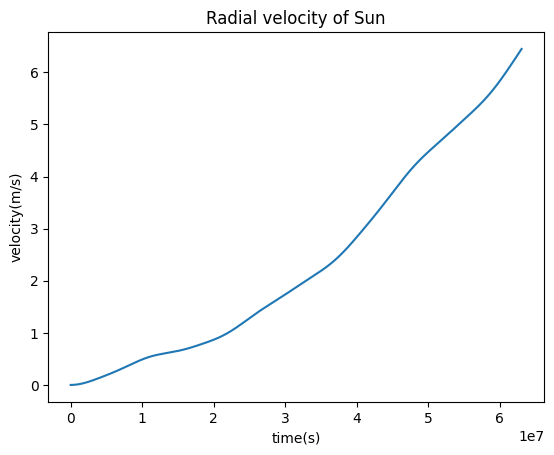

In [7]:
# radial velocity of Sun;
PyPlot.title("Radial velocity of Sun");
plot(sunVelocityTrack.time, sunVelocityTrack.y);
PyPlot.xlabel("time(s)");
PyPlot.ylabel("velocity(m/s)");
savefig("SunRadialVelocity.svg");

In [8]:
# Example 2:
# This example shows the Sun-Earth-Moon system, but the moon use an orbit with z-axis;

simulationTime::BigFloat = 60 * 60 * 24 * (365 * 1);
sysTimeStep::BigFloat = 60 * 60;
angleResolution::BigFloat = 2 * pi / 360;
configure = adfinitasParameters(gravitationalConstant, sysTimeStep, angleResolution);

sunObj = adfinitasObject("Sun", 1.98847 * (BigFloat(10) ^ 30), adfinitasVector(0, 0, 0), adfinitasVector(0, 0, 0), 0);
earthObj =  adfinitasObject("Earth", 5.9722 * (BigFloat(10) ^ 24), adfinitasVector(1.495978707 * (BigFloat(10) ^ 11), 0, 0), adfinitasVector(0, 29780, 0), 0);
moonObj = adfinitasObject("Moon", 7.342 * (BigFloat(10) ^ 22), adfinitasVector(1.495978707 * (BigFloat(10) ^ 11) - 3.84399 * (BigFloat(10) ^ 8) ,0 , 0), adfinitasVector(0, 29780, 1022), 0);

objsArray = adfinitasEmptyObjectArray();
append!(objsArray, [sunObj]);
append!(objsArray, [earthObj]);
objsArray = adfinitasInitObjects(configure, objsArray);

moonObj = adfinitasInitSpecifiedObject(configure, moonObj, earthObj);
append!(objsArray, [moonObj]);

In [9]:
objsMotionList = adfinitasRun(configure, simulationTime, objsArray);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


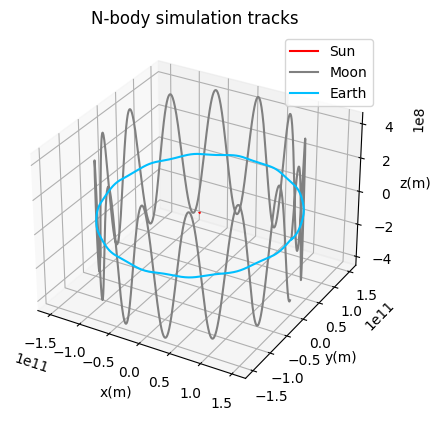

In [10]:
sunPositionTrack, sunVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Sun", objsMotionList));
moonPositionTrack, moonVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Moon", objsMotionList));
earthPositionTrack, earthVelocityTrack = adfinitasConvertTrackArray(adfinitasGetTrack("Earth", objsMotionList));

plot3D(sunPositionTrack.x, sunPositionTrack.y, sunPositionTrack.z, color = "red", marker = " ");
plot3D(moonPositionTrack.x, moonPositionTrack.y, moonPositionTrack.z, color = "grey", marker = " ");
plot3D(earthPositionTrack.x, earthPositionTrack.y, earthPositionTrack.z, color = "deepskyblue", marker = " ");
PyPlot.title("N-body simulation tracks");
PyPlot.xlabel("x(m)");
PyPlot.ylabel("y(m)");
PyPlot.zlabel("z(m)");
legend(["Sun", "Moon", "Earth"]);
savefig("MoonPosition.svg");

In [15]:
# Example 3:
# This example show 1000 body simulation, just like a galaxy;

simulationTime::BigFloat = 60 * 60 * 24 * 365 * (5 * BigFloat(10) ^ 6);
sysTimeStep::BigFloat = 60 * 60 * 24 * 365 * (BigFloat(10) ^ 4);
angleResolution::BigFloat = 2 * pi / 360;
configure = adfinitasParameters(gravitationalConstant, sysTimeStep, angleResolution);

mass = sunObj.mass; # every object's mass is same as Sun;
ly = 9.4607 * (BigFloat(10) ^ 15);  # 1 light year;
objectsArraySize = [10, 10, 10];    # 10 * 10 * 10 objects

objsArray = adfinitasEmptyObjectArray();
for row in 1 : objectsArraySize[1]
    for cow in 1 : objectsArraySize[2]
        for high in 1 : objectsArraySize[3]
            # every object in the simulation list SHOULD has a unique name, or you can not get track from my code conveniently;
            objectTmp = adfinitasObject(string(row) * "," * string(cow) * "," * string(high), mass, adfinitasVector(row * ly, cow * ly, high * ly), adfinitasVector(0, 0, 0), 0);
            append!(objsArray, [deepcopy(objectTmp)]);
        end
    end
end

objsArray = adfinitasInitObjects(configure, objsArray);

In [16]:
objsMotionList = adfinitasRun(configure, simulationTime, objsArray);

Progress: 100%|█████████████████████████████████████████| Time: 0:12:18


sys:1: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
sys:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


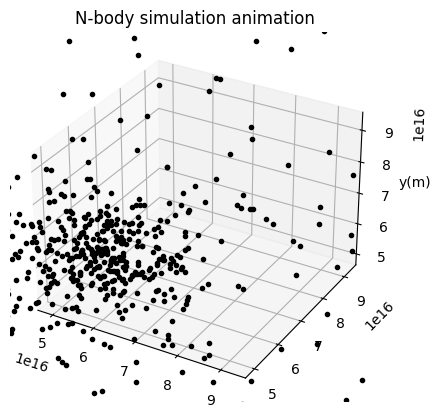

In [22]:
using PyCall
@pyimport matplotlib.animation as animation

fig = figure();

positionTracks = [];
velocityTracks = [];

for row in 1 : objectsArraySize[1]
    for cow in 1 : objectsArraySize[2]
        for high in 1 : objectsArraySize[3]
            positionTrackTmp, velocityTrackTmp = adfinitasConvertTrackArray(adfinitasGetTrack(string(row) * "," * string(cow) * "," * string(high), objsMotionList));
            append!(positionTracks, [positionTrackTmp]);
            append!(velocityTracks, [velocityTrackTmp]);
        end
    end
end

frameLength = length(positionTracks[1].time);
frameStep = floor(frameLength / 100);

function animate(outIndex)
    index = convert(Int64, (outIndex * frameStep)) + 1;
    clf();
    PyPlot.xlabel("x(m)");
    PyPlot.ylabel("y(m)");
    PyPlot.zlabel("y(m)");
    PyPlot.title("N-body simulation animation");
    xlimit = objectsArraySize[1] * Float64(ly);
    PyPlot.xlim([-xlimit * 0.5, xlimit * 1.5]);
    PyPlot.ylim([-xlimit * 0.5, xlimit * 1.5]);
    PyPlot.zlim([-xlimit * 0.5, xlimit * 1.5]);
    xList = [];
    yList = [];
    zList = [];
    for count in 1 : (objectsArraySize[1] * objectsArraySize[2] * objectsArraySize[3])
        append!(xList, positionTracks[count].x[index]);
        append!(yList, positionTracks[count].y[index]);
        append!(zList, positionTracks[count].z[index]);
    end
    plot3D(xList, yList, zList, color = "black", marker = ".", linestyle = " ");
end

function init()
    animate(0);
end

withfig(fig) do 
    anime = animation.FuncAnimation(fig, animate, frames = convert(Int64, floor(frameLength / frameStep)), init_func = init, interval = 5, blit = true); 
    anime.save("animeGalaxyPosition.gif")
end